# Fitbod EDA 


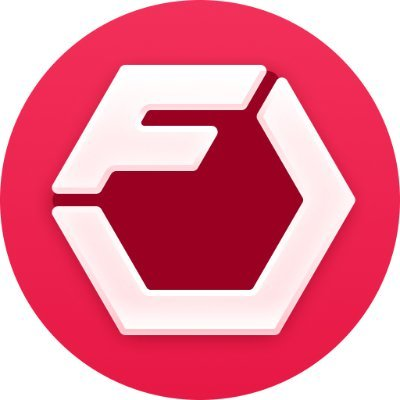

<a id='Business Objective'></a>

## Outline 

**I. Business Objective**
- Key Metrics 

**II. TLDR (Summary)** 
- Business Recommendations 


**III. Assumptions** 

**IV. Analysis**
- Define Target Variable 
- Missing Values 
- **Univariate Analysis**
 - Outliers 
- **Bivariate Analysis** 
- **Contextual Analysis**
- Hypotheseses 


**V. Additional Thoughts** 


### I. Business Objective 

* Fitbod's primary business objective is to increase and maximize total active users. Fitbod achieves this by converting new users into paying customers and providing consumers with a quality experience through great workout recommendations. 

####   Key Metrics 


**Conversion Rate**: 

- Number of conversions is divided by the total number of visitors. 

*Why is it important?*
- Conversions increase the number of paying customers on our platform. It is, therefore, our primary metric for Fitbod to scale quickly.



**Retention Rate**:  
- % of users in period 1 that were active in period 2

*Why is it important?*
- Retention Rate tells us if we satisfy our existing users. A high retention rate results from quality workout recommendations and a positive experience on our app. 



**Monthly Active Users** 
- Number of unique customers who've interacted with the Fitbod platform within the past month. 

*Why is it important?*

Monthly active users describe the overall health of the platform and the effectiveness of any marketing campaigns.


### II. Summary
**Business Recommendations**
-  Allocate advertising spend to Q4, away from Q2, to maximize conversion.


-  Recommend Back Squats, Rear Delt Raises, and Air Squats to consumers during the months of January, April and June


-  Advertise full bodyweight workouts to people who have not converted




### III. Assumptions

* For this exercise, there's an extremely high conversion rate and no missing values.


* However, I will still showcase how I would calculate these elements to show my overall approach to Exploratory Data Analysis.  




* If a single user has more than 3 workouts logged, I'll assume this user has converted, as this is the amount provided in Fitbod's free trial. 


*I will also state my thought process via Markdown throughout the notebook!*




### IV. Analysis 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import scipy 
from scipy import stats

%matplotlib inline 


# Removing warnings that don't affect analysis
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('fitbod_Judley_Joseph_20220404-165635.csv')
df

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
0,2021-01-21,orhfF152EV,zJlvUiMLou,D3rmv5Gc6T,Barbell Incline Bench Press,10,61.235043,fake_id_204
1,2021-07-05,f5jq9ZGNgR,BTmBzxhAmZ,9CEwrB5BVn,Dumbbell Pullover,12,13.607787,fake_id_153
2,2021-09-18,H6l8CvVwom,1sQqqUqJyp,AMT5rDBDFZ,Frog Pump,16,0.000000,fake_id_207
3,2021-10-09,gt1v2eaKav,k3yxx2a6oz,nTADkJQHld,Seated Machine Calf Press,12,106.594334,fake_id_130
4,2021-04-24,EfxG7J6YRc,N6zu9IJNBz,cmC0pSAzKM,Leg Raise,15,0.000000,fake_id_158
...,...,...,...,...,...,...,...,...
50942,2021-05-07,vxEInyjwVA,QFhUumXlvb,mwkfHCSzNa,Reverse Grip Barbell Bent Over Row,12,36.287433,fake_id_127
50943,2021-03-19,rCT26Uppda,N6zu9IJNBz,exV2FTkb6V,Leg Raise,25,0.000000,fake_id_159
50944,2021-07-03,ECtpAM7B0R,4IMiKZHvCG,MoKB8NSwXD,Shotgun Row,20,15.875752,fake_id_132
50945,2021-04-02,MEBxgiUBCA,xPS7RzoOGm,gRfslB0fwt,Bent Over Barbell Row,12,5.669911,fake_id_179


### Target Variable 

**First I will highlight my KPIs before my analysis**
- Conversion Rate
- Month over Month Retention
- Monthly Active Users 

*Conversion Rate is extremely high for our limited dataset, so I'll be using Monthly Active user as a proxy Metric*

 **Conversion Rate Calculation** 

In [5]:
#Count number of distinct users 
users = df['fake_user_id'].unique()

# Assigning a 1 for users who fit conversion criteria , and 0 for those who do not
fake_user_work_id = {}
for user in users:
    new_df = df[df['fake_user_id'] == user]
    #print(len(new_df['workoutId'].value_counts()))
    if len(new_df['workoutId'].value_counts()) > 3:
        
        fake_user_work_id[user] = 1
        
    else:
        fake_user_work_id[user]=0
                
# Add Column showing conversion 
df['converted'] = df['fake_user_id'].map(fake_user_work_id)

#Calculating overall Conversion Rate 
total = df['fake_user_id'].nunique()

subscribers = df[df['converted'] ==1]\
                    ['fake_user_id'].nunique()
conversion_rate = subscribers/total
print(conversion_rate * 100) 

94.11764705882352


*I'll showcase these metrics over time in the Contextual Analysis portion of this EDA*

**Month over Month Retention Rate**

In [6]:
## Breaking down the Date Column into Month and Year 

df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].apply(lambda x: x.month)
df['year'] = df['Date'].apply(lambda x: x.year)
df['week'] = df['Date'].apply(lambda x: x.week)
df['day'] = df['Date'].apply(lambda x: x.day)

# Grouping by by user id and month to calculate month over month Retentiont 

month = pd.DataFrame([1,2,3,4,5,6,7,8,9,10,11,12])
month.columns = ['month']
user_count_by_month = df.groupby(['fake_user_id','month']).count().reset_index()

# If a user logged a workout within that month, I'll consider the user retained 
final_df = []

for user in set(df['fake_user_id'].values):
    user_df = user_count_by_month[user_count_by_month['fake_user_id'] == user]
    
    merged_user = month.merge(user_df,how='left',on='month')
    merged_user['fake_user_id'] = user
    merged_user = merged_user[['month','fake_user_id','Date']]
    merged_user.columns = ['month','fake_user_id','did_workout']
    
    merged_user['did_workout'] = merged_user['did_workout'].fillna(0)
    
    merged_user['did_workout'] = np.where(merged_user['did_workout'] != 0, 1, 0)
    
    merged_user['retained'] = merged_user['did_workout'].shift(-1)
    
    
    final_df.append(merged_user)
    

final_df = pd.concat(final_df)

#final_df.groupby(['month']).mean()['retained'].reset_index()

In [117]:
final_df.groupby(['month']).mean()['retained'].reset_index()

,month,retained
0,1,0.617647
1,2,0.705882
2,3,0.696078
3,4,0.666667
4,5,0.754902
5,6,0.705882
6,7,0.705882
7,8,0.735294
8,9,0.764706
9,10,0.735294


**Monthly Active Users**

In [118]:
mau = df.groupby(['month']).count().reset_index()

mau = mau[['month','Date']]

mau.columns = ['month','count']
mau

,month,count
0,1,4257
1,2,4092
2,3,5038
3,4,4419
4,5,4094
5,6,4038
6,7,4451
7,8,4292
8,9,4049
9,10,4356


## Missing Values 

In [4]:
# Highlighting any missing values from the dataset 

df.isnull().sum()

Date            0
workoutId       0
exerciseId      0
singleSetId     0
exerciseName    0
reps            0
weight          0
fake_user_id    0
dtype: int64

* There is no **missing data**, but if there were, I'd calculate the total missing values per feature and  what percentage of the information is missing in a manner similar to what's below 

In [17]:
total = df.isnull().sum().sort_values(ascending=False)

percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Month,0,0.0
Day,0,0.0
fake_user_id,0,0.0
weight,0,0.0
reps,0,0.0
exerciseName,0,0.0
singleSetId,0,0.0
exerciseId,0,0.0
workoutId,0,0.0
Date,0,0.0


**Breakdown of Analysis**

- Univariate - Descriptive information about my numeric and categorical features. 


- Bivariate/Correlation - Find out how any two components relate to each other through a correlation matrix or multi-variate distribution 


- Contextual - Considering the direct implications that time has in regards to this dataset (primarily month over month retention and MAU) 


### Univariate Analysis 

In [5]:
# Observing the Data Type for Each Column 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50947 entries, 0 to 50946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          50947 non-null  object 
 1   workoutId     50947 non-null  object 
 2   exerciseId    50947 non-null  object 
 3   singleSetId   50947 non-null  object 
 4   exerciseName  50947 non-null  object 
 5   reps          50947 non-null  int64  
 6   weight        50947 non-null  float64
 7   fake_user_id  50947 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.1+ MB


In [4]:
#Descriptive Stats 
numerical_features = df.describe()

#Transpose data so it looks better 
numerical_features = numerical_features.T
numerical_features

,count,mean,std,min,25%,50%,75%,max
reps,50947.0,10.896618,5.423918,0.0,8.0,10.000000,12.000000,120.000000
weight,50947.0,23.858288,56.933115,0.0,0.0,11.339823,36.287433,10936.578639



* From our small dataframe, we can observe the quantiles of our numerical features. The maximum value for both reps and weight looks odd. I will be showcasing this visually as well. 

* I will observe numeric and categorical variables separately



#### Numerical Values 

[Text(0.5, 1.0, 'Weight Boxplot')]

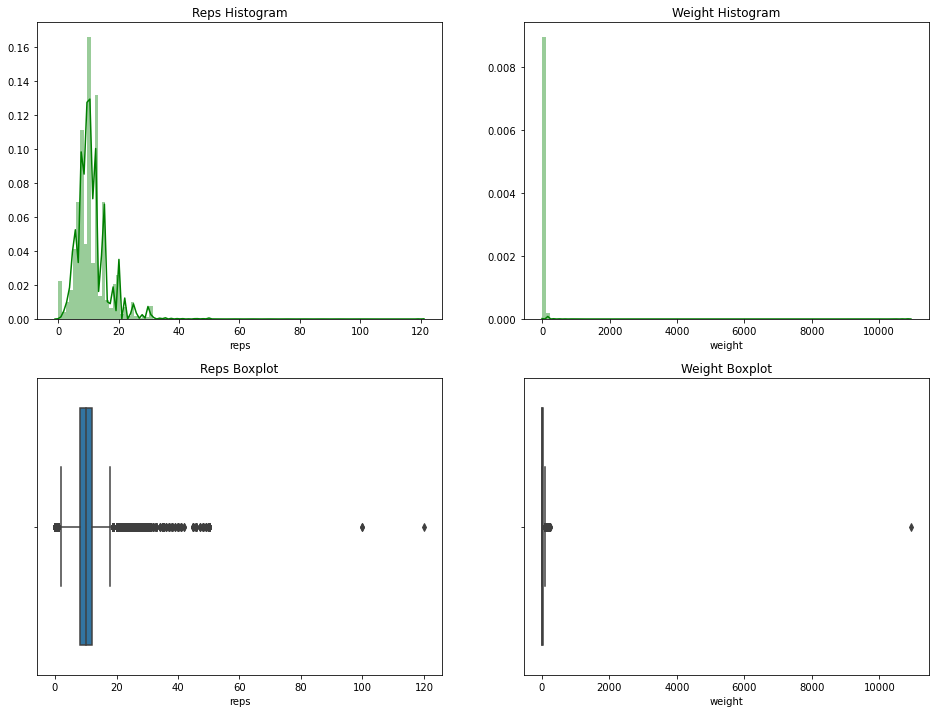

In [5]:
# Reps and Weight Distributions 

fig, saxis = plt.subplots(2, 2,figsize=(16,12))


sns.distplot(df['reps'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax = saxis[0,0]).set(title='Reps Histogram') 

sns.distplot(df['weight'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax = saxis[0,1]).set(title='Weight Histogram')  

sns.boxplot(x=df['reps'], ax =saxis[1,0] ).set(title='Reps Boxplot') 

sns.boxplot(x=df['weight'], ax = saxis[1,1]).set(title='Weight Boxplot') 


 * From our histogram and boxplot, we see that reps are skewed to the right, with 1 value going as high as 120. In addition, we see some values of weight surpassing 10,000 lbs which is unreasonable. 


* The outliers within our dataset are severe and can later prevent us from reaching accurate results. To combat the outliers in our dataset, I'll take the z-score of each row, which tells us how many standard deviations our observation is from the mean.




### Removing Outliers

[Text(0.5, 1.0, 'Weight Boxplot without Outliers')]

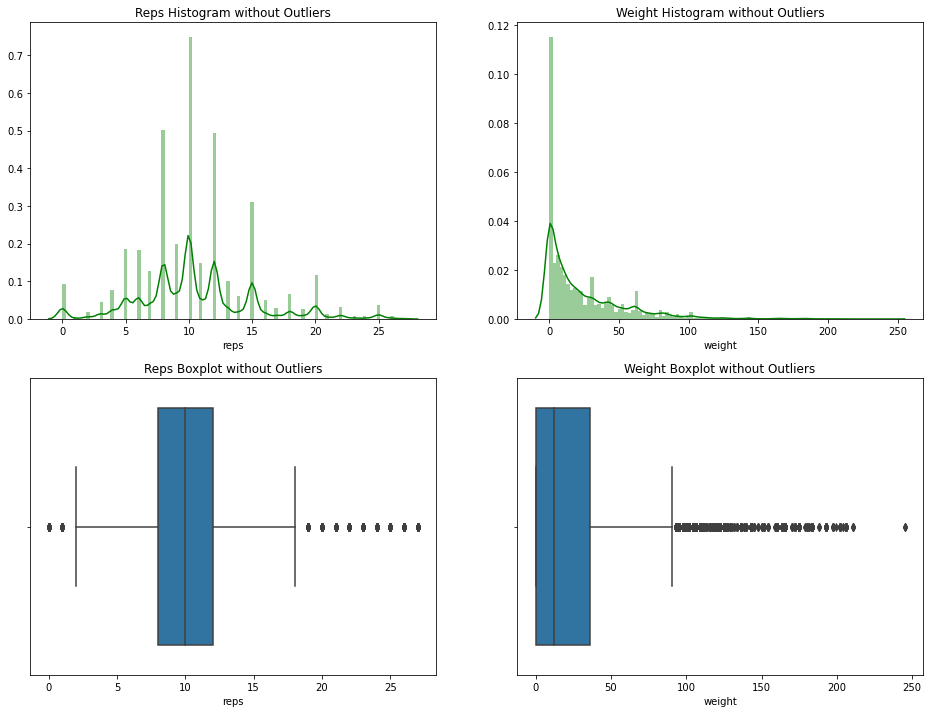

In [7]:
# Removing outliers with z score 
df = df[(np.abs(stats.zscore(df['reps'])) < 3)]


# Plotting the same graphs 
fig, saxis = plt.subplots(2, 2,figsize=(16,12))


sns.distplot(df['reps'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax = saxis[0,0]).set(title='Reps Histogram without Outliers') 
sns.distplot(df['weight'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax = saxis[0,1]).set(title='Weight Histogram without Outliers')  



sns.boxplot(x=df['reps'], ax =saxis[1,0] ).set(title='Reps Boxplot without Outliers')
sns.boxplot(x=df['weight'], ax = saxis[1,1]).set(title='Weight Boxplot without Outliers')

* We now have a much more reasonable graph for both weights in reps. The highest weight is 250 lbs, which is much more realistic than 10,000 lbs. In addition, the reps seem more realistic 


* Moving forward, I will utilize the dataset without the extreme outliers. 


#### Categorical Values 

In [17]:
categorical_features = df[['Date', 'workoutId', 'exerciseId', 'singleSetId', 'exerciseName', 'fake_user_id']]
categorical_features

,Date,workoutId,exerciseId,singleSetId,exerciseName,fake_user_id
0,2021-01-21,orhfF152EV,zJlvUiMLou,D3rmv5Gc6T,Barbell Incline Bench Press,fake_id_204
1,2021-07-05,f5jq9ZGNgR,BTmBzxhAmZ,9CEwrB5BVn,Dumbbell Pullover,fake_id_153
2,2021-09-18,H6l8CvVwom,1sQqqUqJyp,AMT5rDBDFZ,Frog Pump,fake_id_207
3,2021-10-09,gt1v2eaKav,k3yxx2a6oz,nTADkJQHld,Seated Machine Calf Press,fake_id_130
4,2021-04-24,EfxG7J6YRc,N6zu9IJNBz,cmC0pSAzKM,Leg Raise,fake_id_158
...,...,...,...,...,...,...
50942,2021-05-07,vxEInyjwVA,QFhUumXlvb,mwkfHCSzNa,Reverse Grip Barbell Bent Over Row,fake_id_127
50943,2021-03-19,rCT26Uppda,N6zu9IJNBz,exV2FTkb6V,Leg Raise,fake_id_159
50944,2021-07-03,ECtpAM7B0R,4IMiKZHvCG,MoKB8NSwXD,Shotgun Row,fake_id_132
50945,2021-04-02,MEBxgiUBCA,xPS7RzoOGm,gRfslB0fwt,Bent Over Barbell Row,fake_id_179


In [8]:
categorical_features.describe()

,Date,workoutId,exerciseId,singleSetId,exerciseName,fake_user_id
count,50130,50130,50130,50130,50130,50130
unique,365,7428,106,50130,106,102
top,2021-11-09,CYimFaWZKs,G1mxtZtEs5,EvHdpWV4Wo,Back Squat,fake_id_146
freq,274,49,2480,1,2480,2348


Every row from the "singleSetId" is unique, so we won't be able to derive anything helpful from this column alone.

I will only highlight individual Workouts logged and Exercise names (I'll be observing time-based features in the "Contextual Analysis section.") 


Text(0, 0.5, 'Count')

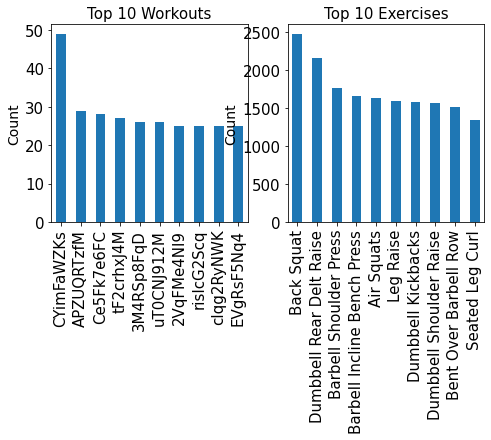

In [86]:
# Graphing the Top 10 workouts, exercises, and sets done by users 

top10_workouts = df.workoutId.value_counts().head(10)
top10_exercises = df.exerciseName.value_counts().head(10)



plt.figure(figsize=[16,12])

plt.subplot(231)
top10_workouts.plot(kind = "bar", fontsize = 15, figsize=(12,8))
plt.title("Top 10 Workouts", fontsize = 15)
plt.ylabel("Count", fontsize = 14)
#plt.xticks(rotation=60)



plt.subplot(232)
top10_exercises.plot(kind = "bar", fontsize = 15, figsize=(12,8))
plt.title("Top 10 Exercises", fontsize = 15)
plt.ylabel("Count", fontsize = 14)



### What are the most popular workouts? How can we reverse engineer these workouts to improve total active users?

In [119]:
df.workoutId.value_counts().head(10)

CYimFaWZKs    49
APZUQRTzfM    29
Ce5Fk7e6FC    28
tF2crhxJ4M    27
3M4RSp8FqD    26
uT0CNJ912M    26
2VqFMe4NI9    25
risIcG2Scq    25
cIqg2RyNWK    25
EVgRsF5Nq4    25
Name: workoutId, dtype: int64

In [120]:
set(df[df['workoutId'] == 'CYimFaWZKs']['exerciseName'].values)

{'Barbell Shoulder Press', 'Dumbbell Squeeze Press', 'Machine Fly'}

*We will explore this concept further in the following sections*

### BIVARIATE ANALYSIS  




In this section, I want to see how conversions relate to other features within the dataset. 


*I will be observing how month over month Retention relates to other features within the Contextual Analysis portion of this EDA* 









**How do our workouts affect conversion rate?**



A **Double Bar Chart** will effectively showcase the relationship between a Discrete Numerical category (our "converted" column) and the frequency of workouts. 
This will allow us to view side by side what workouts result in conversion and which activities do not


* Due to the sheer number of different workouts, I will only showcase workouts that have appeared 20 or more times 


In [9]:
# Filter the top 20 workoutIds 

frequency_dict = dict(df.workoutId.value_counts())

df['frequency'] = df['workoutId'].map(frequency_dict)
df.head()

new_df = df[df['frequency'] > 19]


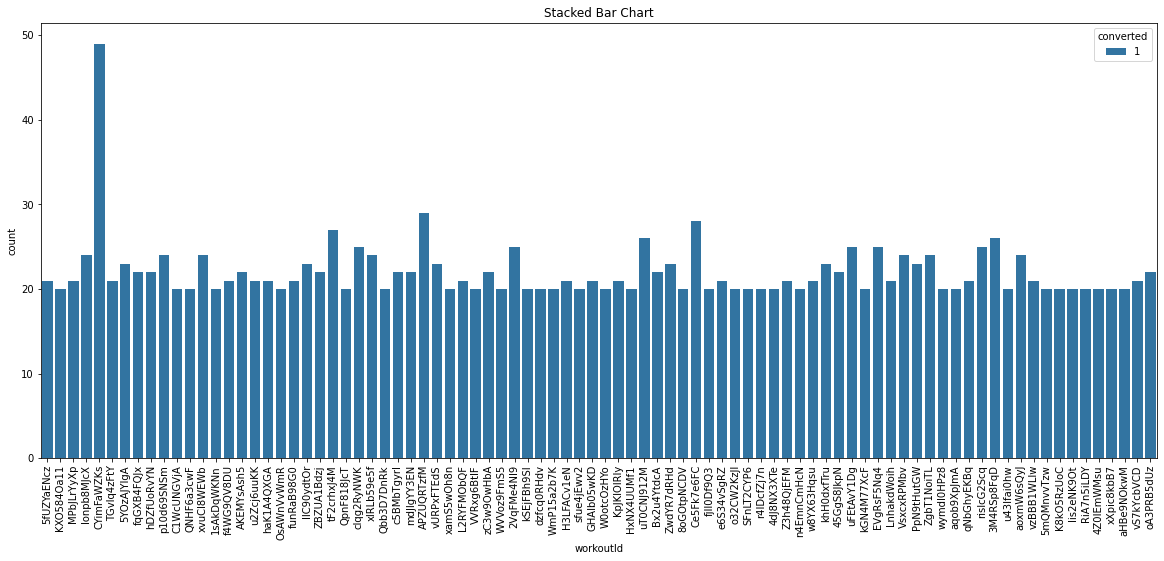

In [126]:
plt.figure(figsize = (20,8))
plt.xticks(rotation = 90)
sns.countplot(x = 'workoutId' , hue = 'converted' , data = new_df, palette=["C0", "C1", "k"]).set_title('Double Bar Chart')
plt.show()





* Surprisingly, workouts that appear 20 or more times  always result in a converted user.


* In other words, we should recommend these specific workouts since they have a  **100%** conversion rate




**How do specific Exercises affect conversion?**

I want to know if specific exercises result in higher conversion for our consumers. 

* Similar to our previous graph, I will be using a **double bar chart** for a side-by-side view of exercises resulting in conversion.


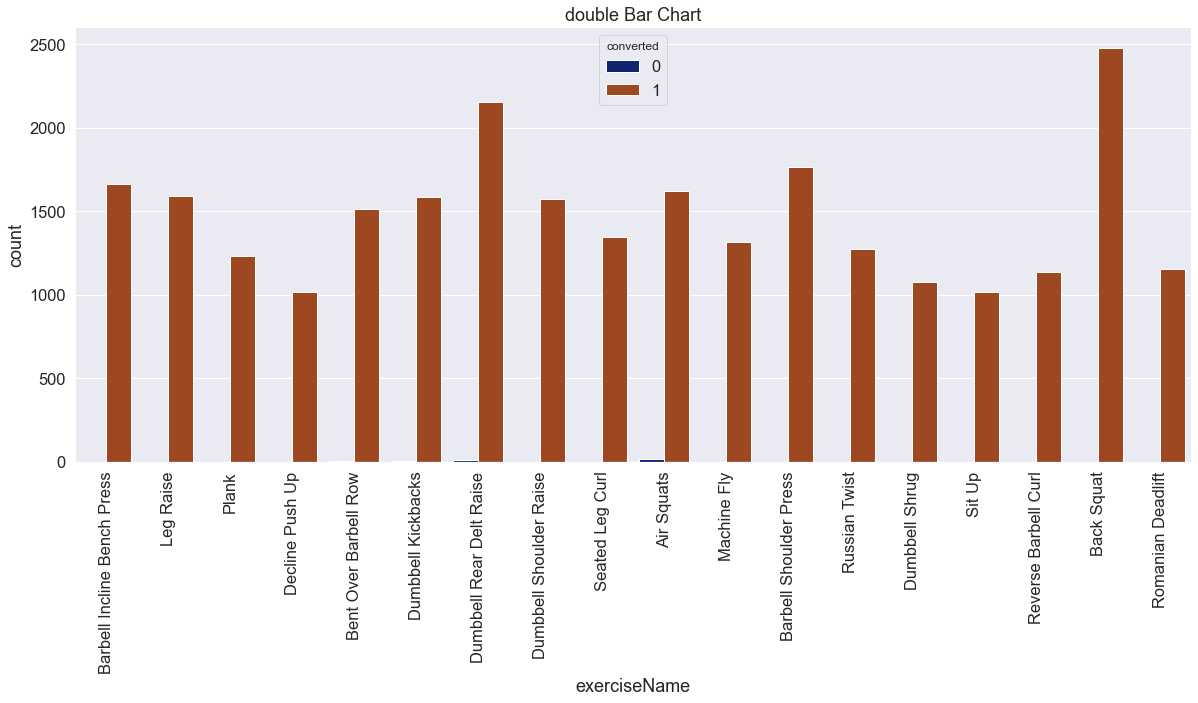

In [89]:
# Creating a frequency column for individual exercises, as this could bring further insight 

ex_freq = dict(df['exerciseName'].value_counts())
df['ex_freq'] = df['exerciseName'].map(ex_freq)

# Filter exercises for those that appear more than 1000 times 
new_df2 = df[df['ex_freq'] > 1000]



#Stacked Bar Chart 
plt.figure(figsize = (20,8))
plt.xticks(rotation = 90)
sns.countplot(x = 'exerciseName' , hue = 'converted' , data = new_df2, palette=["C0", "C1", "k"]).set_title('double Bar Chart')
plt.show()

* From our graph, 15 out of 20 exercises result in a 100% conversion rate.  




* When Planks, Bent Over Barbell Row, Dumbell Rear Delt Raise, and Air Squats are recommended, a small percentage of them did not convert into full-time paying members. 




* In other words, recommending these specific exercises less could result in higher conversion in the long run. 


**How does conversion relate to our other features?**

* A **Heatmap** effectively showcases areas of interest, specifically which variables correlate the most with each other.


* We can see the effect our converted column has on other features. 


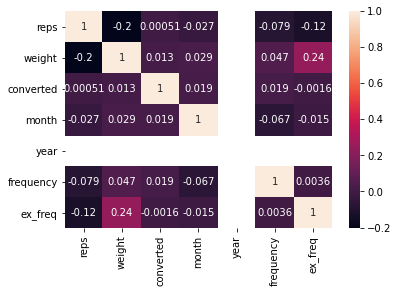

In [53]:
sns.heatmap(df.corr(),annot = True)

### Correlation does not equal causation! But it does give us an excellent place to start regarding further testing.


*Some  insight from the heatmap include*


*  Because our converted column has a relationship with the month, I will conduct an A | B test on that specific aspect. (in the "Hypotheses" section) to see if conversion is higher in particular quarters




* There is a negative relationship between weights and reps, which make sense. Generally, the higher the reps, the lower the weight 


* The higher the weight, the more frequently that specific exercises appear. 






## Contextual Anaylysis 

**Month over Month Retention**

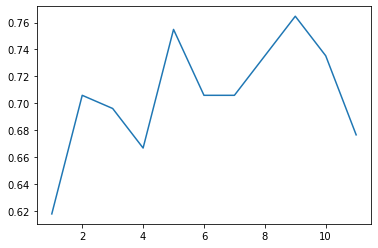

In [79]:
# Quick Graph 
rr = final_df.groupby(['month']).mean()['retained'].reset_index()

rr = rr[['month','retained']]

rr.columns = ['month','avg']

plt.plot(rr['month'],rr['avg'])

**From our graph, we see that retention was highest during May and September.**

* We can observe what workouts were popular during this period to see what factors increased our retention rate. (I will explore this in the Hypothesis section)


**Monthly Active Users** 

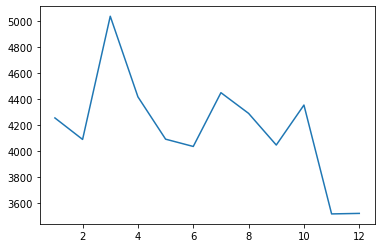

In [102]:
mau = df.groupby(['month']).count().reset_index()

mau = mau[['month','Date']]

mau.columns = ['month','count']

plt.plot(mau['month'],mau['count'])

**Monthly active users were highest in March, and in July**

* We see a big dropoff towards the end of the year, starting in October.

**Daily Active Users**

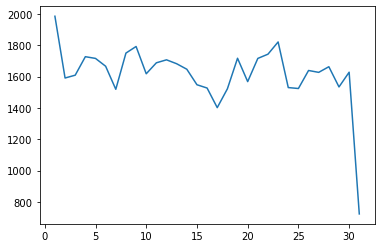

In [132]:
dau = df.groupby(['day']).count().reset_index()

dau = dau[['day','Date']]

dau.columns = ['day','count']

plt.plot(dau['day'],dau['count'])

**On average, more users utilize Fitbod in the beginning of the month. We also  app sees a rapid drop towards the end of the month**

## Hypotheses

* Here I will aggregate my most important insights, form hypotheses, and base my findings on the data.

### 1.) Does the proportion of conversion change at different times of the year?

* Since conversion correlates with month, I want to dive deeper and investigate the two elements. To do so, I'll conduct an A | B test to observe my features. 

*  Chi-Squared Tests are effective in showcasing independence between categorical features. 


* I will also break down months into quarters. 

Q1 - Jan, Feb, Mar

Q2 - Apr, May, June

Q3 - July, Aug, Sept 

Q4 - Oct, Nov Dec


Null Hypothesis: There is no statistical significance between Conversion and the month that conversion occurs. 

Alternative Hypothesis: There is statistical significance between Conversion and the month that conversion occurs. 


In [115]:
from scipy.stats import chi2_contingency
 
    
# Dividing months into Quarters 
df['quarter'] = df['Date'].dt.quarter    

#The easiest way to apply a chi-squared test is to compute the contigency table.
contigency= pd.crosstab(df['converted'], df['quarter'])
contigency

quarter,1,2,3,4
converted,,,,
0,22,33,19,0
1,13365,12518,12773,11400


In [116]:
c, p, dof, expected = chi2_contingency(contigency)
 
print("p_value: ",round(p,3))

p_value:  0.0


**the p-value is an extremely small number.**

**This suggests that there's strong evidence against  our null hypothesis, meaning the month is a significant factor in determining conversion.** 


From our contingency table, we see that the quarter where the number of people converted is the lowest is within the 4th quarter. 




**Recommendation**

* We can advise marketing to run fewer campaigns in Q2 since conversions are already high. We should allocate spending to marketing campaigns before Q4 (slightly before October) to maximize conversion.

* We can also focus marketing initiatives on lagging months via Email notifications to encourage consumers to become paying customers and detail the benefits of Fitbod in giving a head start on the New Year gym crowd  :)


## 2.) Do certain kinds of exercises cause users to retain better? 

- We can test this by seeing the highest month of retentions and see what workouts were recommended during that time period


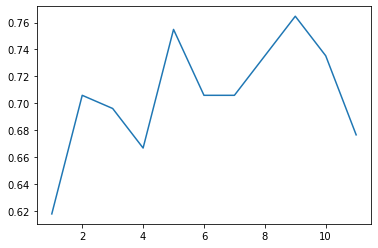

In [134]:
rr = final_df.groupby(['month']).mean()['retained'].reset_index()

rr = rr[['month','retained']]

rr.columns = ['month','avg']

plt.plot(rr['month'],rr['avg'])

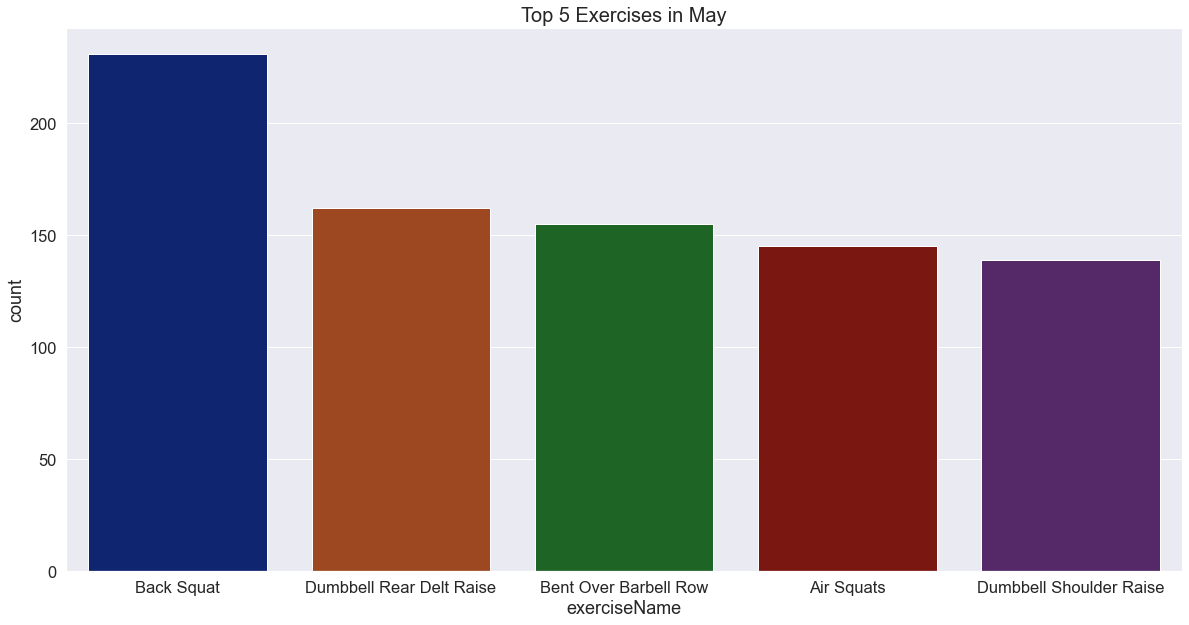

In [69]:
may_df = df[df['month'] == 5]

top5_may = may_df.exerciseName.value_counts().head()

may_exercises = may_df[may_df.exerciseName.isin(top5_may.index)]

#Bar Chart for Exercises in May 
plt.figure(figsize=(20,10))
sns.set(font_scale=1.5, palette= "dark")
sns.countplot(data = may_exercises, x = "exerciseName", order = top5_may.index)
plt.title("Top 5 Exercises in May", fontsize = 20)
plt.show()


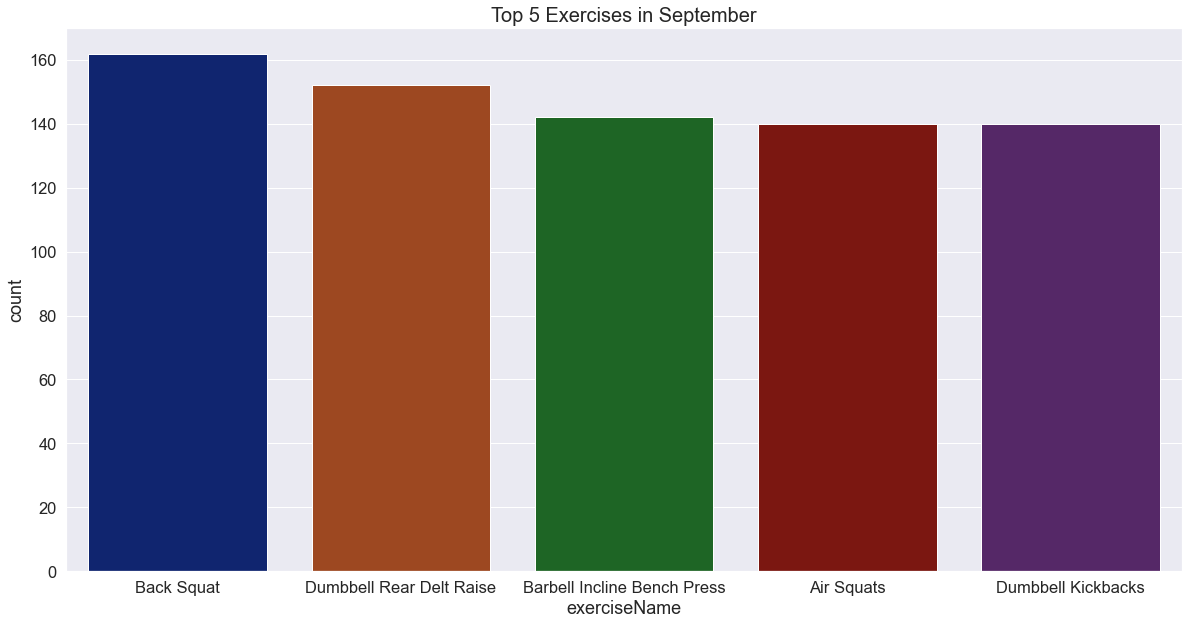

In [68]:
september_df = df[df['month'] == 9]

top5_september = september_df.exerciseName.value_counts().head()

september_exercises = september_df[september_df.exerciseName.isin(top5_september.index)]

#Bar Chart for Exercises in September
plt.figure(figsize=(20,10))
sns.set(font_scale=1.5, palette= "dark")
sns.countplot(data = september_exercises, x = "exerciseName", order = top5_september.index)
plt.title("Top 5 Exercises in September", fontsize = 20)
plt.show()


* Is is normal to assume that retention is due to the quality of recommendations that our consumers receive.

**Recommendation**
* By recommending the same exercises that appeared in peak retention months, to lower retention months, we can improve retention across the board. 

## 3.)  How do bodyweight exercises affect conversion, how do non converted users respond to bodweight exercises


* I'll calculate conversion rate for users engaged in only bodweight exercises, and those who include weighted exercises

In [90]:


bw_df = df[df['weight'] == 0]
total2 = bw_df['fake_user_id'].nunique()

subscribers2 = bw_df[bw_df['converted'] ==1]\
                    ['fake_user_id'].nunique()
conversion_rate2 = subscribers2/total2
print(conversion_rate2 * 100) 

94.89795918367348


In [91]:
ww_df = df[df['weight'] > 0]
total3 = ww_df['fake_user_id'].nunique()

subscribers3 = ww_df[ww_df['converted'] ==1]\
                    ['fake_user_id'].nunique()
conversion_rate3 = subscribers3/total3
print(conversion_rate3 * 100) 

95.04950495049505


**Recommendations**


* Because conversion rate are relatively similar, we can advertise full bodyweight workouts to people who have not converted.


* People may think that they'll start using a gym, tell Fitbod they have access to certain equipment, but never end up logging 3 workouts. 


* To convert said users, send an email or push notifcation that will automatically modify a bodyweight regiment for them 

### Additional Thoughts 

* I conducted this analysis with the thought of crafting a 10 - 15 minute presention. If were conducting a deeper dive, I woudl have performed some type of textual analysis
